Now as a project, we'll experiment with recurrent networks and learn a *language model*. A language model is simply a network that predicts the next word or character when trained on a set of data. 

We'll train on a set of quotes, and create our own inspirational quote generator.

In [1]:
from ipywidgets import FloatProgress
from IPython.display import display

import mxnet as mx
from mxnet import nd, autograd
import matplotlib.pyplot as plt
from mxnet import gluon, autograd
from mxnet.gluon import nn, rnn
mx.random.seed(1)
# switch this to cpu if you don't have a gpu
#ctx = mx.cpu()
context = mx.gpu()

from keras.preprocessing.text import Tokenizer

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open("../quotes.txt", 'r', encoding='utf8') as f:
    quotes = f.read().lower()

Now, we cannot exactly use text as is, we need to turn it into numbers. To do this, we'll use the `Tokenizer` to generate word to number mappings.

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([quotes])

Now we have a list of numbers rather than a string of characters.

In [4]:
ordinals = tokenizer.texts_to_sequences([quotes])[0]
ordinals[0:10]

[790, 12, 3252, 4715, 13, 123, 56, 790, 1, 217]

Hmm -- how many unique words did we find?

In [5]:
len(tokenizer.word_index)

35454

OK -- working with sequences, we need something to predict. That will be -- the next character. So, for any given sequence of a given length, the next character from the source text will be the output. This means we'll be taking out one hot array and chopping it into sequences for input, and single characters as output.

This will take a *while*.

In [6]:
sequence_length = 32
chunks = len(ordinals) // sequence_length
inputs = []
outputs = []
for i in range(0, (chunks*sequence_length)-sequence_length):
    inputs.append(nd.array(ordinals[i:i+sequence_length], dtype='int32'))
    #careful here -- easy to end up off-by-one
    outputs.append(nd.array([ordinals[i+sequence_length]], dtype='int32').one_hot(len(tokenizer.word_index)))

Create a dataset, we'll use this for the actual training loop.

In [7]:
batch_size = 32
dataset = mx.gluon.data.dataset.ArrayDataset(inputs, outputs)
data_loader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size)

Now we'll do a bit more advanced gluon -- and make a network that can encode and decode a recurrent string network.

This starts with embedding the integer representing each word -- this turns an index of a single word into a floating point array better suited for machine learning. Then we run a recurrent network -- it loops over each word position, feeding the network into itself on each step. 

Finally, we do a dense output to generate one hot encodings for outputs.

We're going to use RMSProp, since we had great learning results with it earlier. And -- softmax cross entropy loss -- but we'll set the `sparse_label=False` because we're have one hot encodings as our output labels as well as out model output from our dense layer.

In [8]:
vocabulary_size = len(tokenizer.word_index)
number_embedding_layers = 128
number_hidden_layers = 256
number_layers = 2
dropout = 0.2


model =  gluon.nn.Sequential()
model.add(gluon.nn.Embedding(vocabulary_size, number_embedding_layers))
model.add(gluon.rnn.LSTM(number_hidden_layers, number_layers, dropout=dropout))
model.add(gluon.nn.BatchNorm(2))
model.add(gluon.nn.Dropout(dropout))
model.add(gluon.nn.Dense(vocabulary_size, activation='relu', flatten=True))
model.initialize(mx.init.Xavier(), ctx=context)

trainer = gluon.Trainer(model.collect_params(), 'rmsprop')
loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

In [9]:
def learn(model, trainer, loss_function, batch_size):
    
    epochs = 512
    losses = []
    
    f = FloatProgress(min=0, max=epochs) # instantiate the bar
    display(f) # display the bar
    for e in range(epochs):
        for input_batch, output_batch in data_loader:
            input_batch = input_batch.as_in_context(context)
            output_batch = output_batch.as_in_context(context)
            with autograd.record():
                predicted = model(input_batch)
                loss = loss_function(predicted, output_batch)
                loss.backward()
            trainer.step(input_batch.shape[0])
            break

        f.value += 1
        losses.append(nd.sum(loss).asscalar())
    return losses

In [10]:
losses = learn(model, trainer, loss, batch_size)

FloatProgress(value=0.0, max=512.0)

In [11]:
import numpy as np
def plot_loss(total_loss):
    x_axis = np.linspace(0, len(total_loss), len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

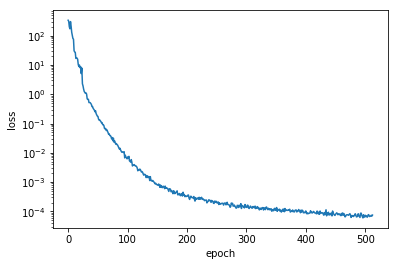

7.498249e-05

In [12]:
plot_loss(losses)
losses[-1]

Now - we can use our language model to generate some text. We'll need out own softmax function.

In [13]:
def softmax(y_linear, temperature=1.0):
    lin = (y_linear-nd.max(y_linear, axis=1).reshape((-1,1))) / temperature # shift each row of y_linear by its max
    exp = nd.exp(lin)
    partition =nd.sum(exp, axis=1).reshape((-1,1))
    return exp / partition

Each string will need to be in a matrix, and formulated as a 'batch'. We'll space pre-pad, and trim as needed to make sure we are the correct sequence length for our model.

This will work on the tails of strings, so we can keep tacking characters on to a base seed and continue to generate output.

In [14]:
def encode_string(s, max_len=sequence_length):
    ret = nd.zeros((sequence_length,), dtype='int32').as_in_context(context)
    ordinals = tokenizer.texts_to_sequences([s])[0][-max_len:]
    encoded = nd.array(ordinals, dtype='int32').as_in_context(context)
    ret[-len(encoded):] = encoded
    return ret.expand_dims(0)

In [15]:
encode_string('Can we have')


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 37 19 32]]
<NDArray 1x32 @gpu(0)>

And we'll make a decoder function that turns a model output into a character.

In [16]:
def decode_string(model_output):
    return tokenizer.sequences_to_texts([[softmax(model_output).argmax(1).astype('int32').asscalar()]])

In [17]:
decode_string(nd.array([37], dtype='int32').one_hot(len(tokenizer.word_index)))

['can']

Now we can use our model and start to make predictions.

And now -- the finale -- generating strings with our model.

In [18]:
def generate(seed, max_length=64):
    gen = seed
    while True:
        to_append = decode_string(model(encode_string(gen)))[0]
        gen = gen + ' ' + to_append
        if to_append == '\n' or len(gen) == max_length:
            return gen

In [ ]:
generate('Can we have a paper')